# Key Levels mix kmeeans clustering (v3)

In [1]:
## VN30ps/clusters/kmeans3

In [2]:
import warnings
warnings.filterwarnings('ignore')

import time
from datetime import date, datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.cluster import KMeans
import pickle

In [3]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/VN30ps/clusters/kmeans3/VN30F1M_5m_data_train.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    dataset = []
dataset

,Open,High,Low,Close,Volume,input_1,input_2,input_3,single_cluster,cluster_shift,cluster_shift2,pattern_cluster
Date,,,,,,,,,,,,
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329,-0.5,0.5,0.0,91,0.0,13.0,120
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722,-0.9,0.4,-0.8,86,91.0,0.0,23
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939,-0.4,1.7,-0.3,14,86.0,91.0,189
2020-11-02 09:25:00,898.3,898.6,897.8,898.5,1607,-0.1,0.7,0.2,63,14.0,86.0,102
2020-11-02 09:30:00,898.5,899.4,898.3,899.0,1623,-0.4,0.7,0.5,4,63.0,14.0,160
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26 14:15:00,1229.9,1230.5,1227.3,1229.4,7567,-1.1,2.1,-0.5,89,28.0,84.0,25
2024-04-26 14:20:00,1229.8,1235.9,1229.4,1232.4,15934,-3.5,3.0,2.6,95,89.0,28.0,191
2024-04-26 14:25:00,1232.5,1236.5,1232.1,1232.1,13075,-4.4,0.0,-0.4,65,95.0,89.0,53


In [4]:
data = dataset.copy()
back_bar = 20
next_bar = back_bar -1
data['max_prev'] = data['Open'].rolling(back_bar).max()
data['max_next'] = data['Open'].shift(-next_bar).rolling(back_bar).max()
data['min_prev'] = data['Open'].rolling(back_bar).min()
data['min_next'] = data['Open'].shift(-next_bar).rolling(back_bar).min()
data["RSI"] = ta.rsi(data["Close"], length=14)
data["ema"] = ta.ema(data["Close"], length=20)
data["diff_ema"] = data["ema"] - data["Close"]
data["ma_20_vol"] = data["Volume"].rolling(20).mean()
data['vol_rate'] = data.apply(
        lambda x: round(x["Volume"] / x["ma_20_vol"], 2), axis=1)
data

,Open,High,Low,Close,Volume,input_1,input_2,input_3,single_cluster,cluster_shift,...,pattern_cluster,max_prev,max_next,min_prev,min_next,RSI,ema,diff_ema,ma_20_vol,vol_rate
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329,-0.5,0.5,0.0,91,0.0,...,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722,-0.9,0.4,-0.8,86,91.0,...,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939,-0.4,1.7,-0.3,14,86.0,...,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-02 09:25:00,898.3,898.6,897.8,898.5,1607,-0.1,0.7,0.2,63,14.0,...,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-02 09:30:00,898.5,899.4,898.3,899.0,1623,-0.4,0.7,0.5,4,63.0,...,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26 14:15:00,1229.9,1230.5,1227.3,1229.4,7567,-1.1,2.1,-0.5,89,28.0,...,25,1233.7,NaN,1226.4,NaN,48.767244,1229.747871,0.347871,7346.05,1.03
2024-04-26 14:20:00,1229.8,1235.9,1229.4,1232.4,15934,-3.5,3.0,2.6,95,89.0,...,191,1233.2,NaN,1226.4,NaN,55.098622,1230.000455,-2.399545,7813.10,2.04
2024-04-26 14:25:00,1232.5,1236.5,1232.1,1232.1,13075,-4.4,0.0,-0.4,65,95.0,...,53,1232.5,NaN,1226.4,NaN,54.374963,1230.200412,-1.899588,8162.30,1.60


In [5]:
data.dropna(inplace=True)
data['is_r_keylevel'] = data.apply(lambda r: True if (r['Open'] == r['max_prev'] and r['Open'] == r['max_next']) else False, axis=1)
data['is_s_keylevel'] = data.apply(lambda r: True if (r['Open'] == r['min_prev'] and r['Open'] == r['min_next']) else False, axis=1)
data

,Open,High,Low,Close,Volume,input_1,input_2,input_3,single_cluster,cluster_shift,...,max_next,min_prev,min_next,RSI,ema,diff_ema,ma_20_vol,vol_rate,is_r_keylevel,is_s_keylevel
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-02 10:45:00,899.4,900.2,896.7,897.9,3197,-2.3,1.2,-1.5,34,63.0,...,899.4,898.1,896.3,40.250000,899.315000,1.415000,1873.65,1.71,False,False
2020-11-02 10:50:00,897.8,898.9,896.8,898.3,2997,-0.6,1.5,0.5,59,34.0,...,900.4,897.8,896.3,43.172826,899.218333,0.918333,1957.05,1.53,False,False
2020-11-02 10:55:00,898.0,898.3,897.2,897.3,1668,-1.0,0.1,-0.7,86,59.0,...,902.5,897.8,896.3,38.148609,899.035635,1.735635,1954.35,0.85,False,False
2020-11-02 11:00:00,897.3,897.4,895.4,897.0,3418,-0.4,1.6,-0.3,14,86.0,...,902.5,897.3,896.3,36.766273,898.841765,1.841765,1978.30,1.73,False,False
2020-11-02 11:05:00,896.9,898.1,896.4,897.6,2101,-0.5,1.2,0.7,61,14.0,...,902.5,896.9,896.3,41.344118,898.723502,1.123502,2003.00,1.05,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26 11:15:00,1233.7,1235.0,1233.1,1233.5,6593,-1.5,0.4,-0.2,27,8.0,...,1233.7,1224.9,1226.4,53.245671,1233.639620,0.139620,5506.95,1.20,False,False
2024-04-26 11:20:00,1233.2,1234.0,1232.0,1232.0,6091,-2.0,0.0,-1.2,11,27.0,...,1233.2,1224.9,1226.4,48.169747,1233.483466,1.483466,5674.15,1.07,False,False
2024-04-26 11:25:00,1232.3,1232.4,1228.3,1228.3,10859,-4.1,0.0,-4.0,69,11.0,...,1232.5,1225.1,1226.4,38.436284,1232.989802,4.689802,6116.70,1.78,False,False


In [6]:
data['prev_is_r_keylevel'] = data['is_r_keylevel'].shift(1)
data['prev_is_s_keylevel'] = data['is_s_keylevel'].shift(1)

In [7]:
data

,Open,High,Low,Close,Volume,input_1,input_2,input_3,single_cluster,cluster_shift,...,min_next,RSI,ema,diff_ema,ma_20_vol,vol_rate,is_r_keylevel,is_s_keylevel,prev_is_r_keylevel,prev_is_s_keylevel
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-02 10:45:00,899.4,900.2,896.7,897.9,3197,-2.3,1.2,-1.5,34,63.0,...,896.3,40.250000,899.315000,1.415000,1873.65,1.71,False,False,NaN,NaN
2020-11-02 10:50:00,897.8,898.9,896.8,898.3,2997,-0.6,1.5,0.5,59,34.0,...,896.3,43.172826,899.218333,0.918333,1957.05,1.53,False,False,False,False
2020-11-02 10:55:00,898.0,898.3,897.2,897.3,1668,-1.0,0.1,-0.7,86,59.0,...,896.3,38.148609,899.035635,1.735635,1954.35,0.85,False,False,False,False
2020-11-02 11:00:00,897.3,897.4,895.4,897.0,3418,-0.4,1.6,-0.3,14,86.0,...,896.3,36.766273,898.841765,1.841765,1978.30,1.73,False,False,False,False
2020-11-02 11:05:00,896.9,898.1,896.4,897.6,2101,-0.5,1.2,0.7,61,14.0,...,896.3,41.344118,898.723502,1.123502,2003.00,1.05,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26 11:15:00,1233.7,1235.0,1233.1,1233.5,6593,-1.5,0.4,-0.2,27,8.0,...,1226.4,53.245671,1233.639620,0.139620,5506.95,1.20,False,False,False,False
2024-04-26 11:20:00,1233.2,1234.0,1232.0,1232.0,6091,-2.0,0.0,-1.2,11,27.0,...,1226.4,48.169747,1233.483466,1.483466,5674.15,1.07,False,False,False,False
2024-04-26 11:25:00,1232.3,1232.4,1228.3,1228.3,10859,-4.1,0.0,-4.0,69,11.0,...,1226.4,38.436284,1232.989802,4.689802,6116.70,1.78,False,False,False,False


In [8]:
keylevel_data = data[(data['is_r_keylevel'] == True) | (data['is_s_keylevel'] == True)]
len(keylevel_data)

1626

In [9]:
top_data = data[data['is_r_keylevel'] == True]
bot_data = data[data['is_s_keylevel'] == True]
rac_data = data[(data['is_r_keylevel'] != True) & (data['is_s_keylevel'] != True)]

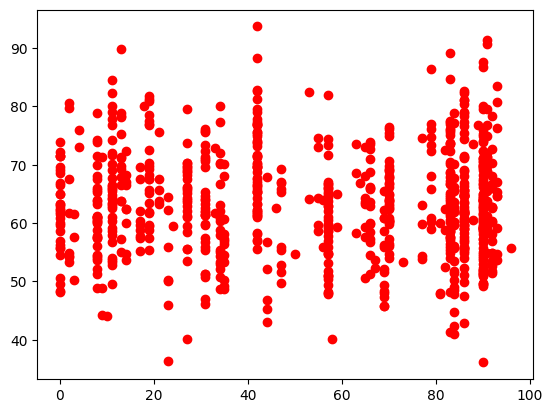

In [10]:
plt.scatter(top_data['single_cluster'], top_data['RSI'], c='red')

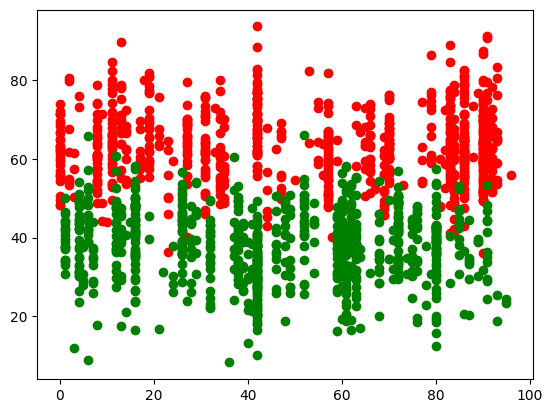

In [11]:
plt.scatter(top_data['single_cluster'], top_data['RSI'], c='red')
plt.scatter(bot_data['single_cluster'], bot_data['RSI'], c='green')
# plt.scatter(normal_data['pattern_cluster'], normal_data['RSI'], c='yellow')

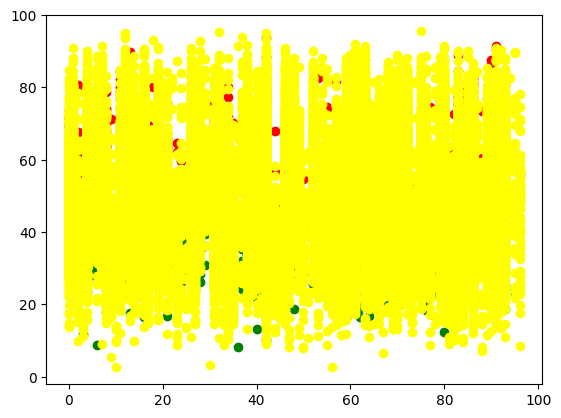

In [12]:
plt.scatter(top_data['single_cluster'], top_data['RSI'], c='red')
plt.scatter(bot_data['single_cluster'], bot_data['RSI'], c='green')
plt.scatter(rac_data['single_cluster'], rac_data['RSI'], c='yellow')

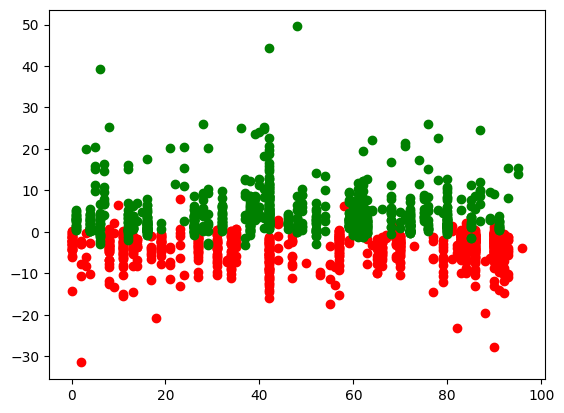

In [13]:
plt.scatter(top_data['single_cluster'], top_data['diff_ema'], c='red')
plt.scatter(bot_data['single_cluster'], bot_data['diff_ema'], c='green')

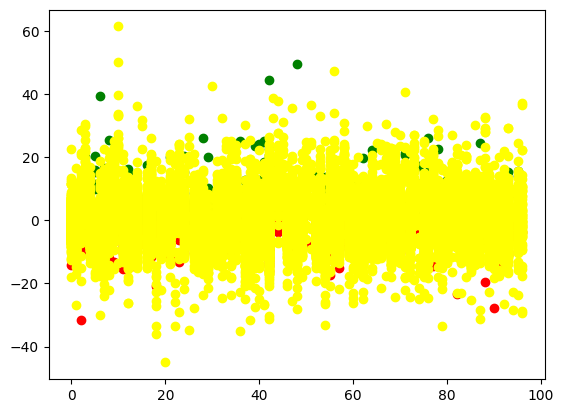

In [14]:
plt.scatter(top_data['single_cluster'], top_data['diff_ema'], c='red')
plt.scatter(bot_data['single_cluster'], bot_data['diff_ema'], c='green')
plt.scatter(rac_data['single_cluster'], rac_data['diff_ema'], c='yellow')

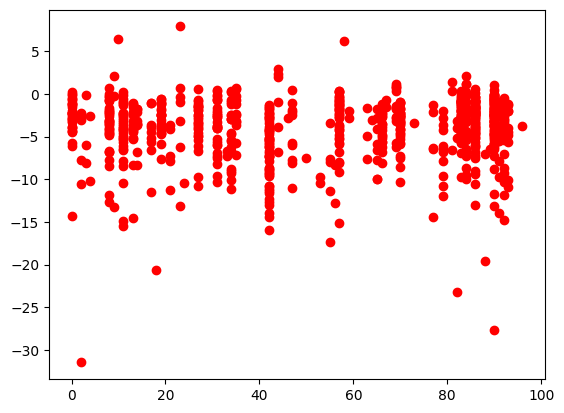

In [15]:
plt.scatter(top_data['single_cluster'], top_data['diff_ema'], c='red')

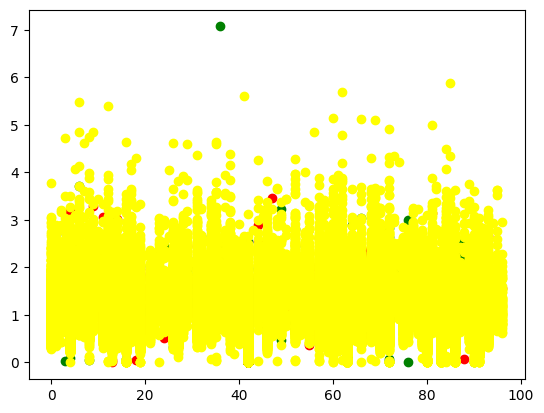

In [16]:
plt.scatter(top_data['single_cluster'], top_data['vol_rate'], c='red')
plt.scatter(bot_data['single_cluster'], bot_data['vol_rate'], c='green')
plt.scatter(rac_data['single_cluster'], rac_data['vol_rate'], c='yellow')

In [17]:
supply_data = data[data['prev_is_r_keylevel'] == True]
demand_data = data[data['prev_is_s_keylevel'] == True]
normal_data = data[(data['prev_is_r_keylevel'] != True) & (data['prev_is_s_keylevel'] != True)]

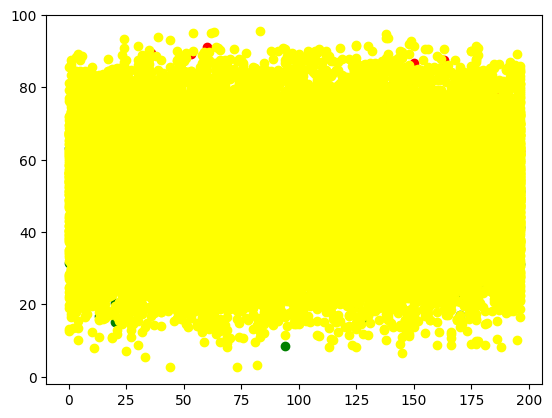

In [18]:
plt.scatter(supply_data['pattern_cluster'], supply_data['RSI'], c='red')
plt.scatter(demand_data['pattern_cluster'], demand_data['RSI'], c='green')
plt.scatter(normal_data['pattern_cluster'], normal_data['RSI'], c='yellow')

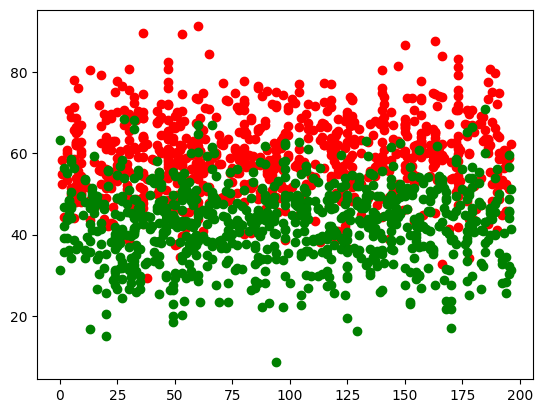

In [19]:
plt.scatter(supply_data['pattern_cluster'], supply_data['RSI'], c='red')
plt.scatter(demand_data['pattern_cluster'], demand_data['RSI'], c='green')

In [20]:
#Short
grouped_a = supply_data[['pattern_cluster']].groupby([supply_data.pattern_cluster]).count().rename(columns={'pattern_cluster': 'count'})
grouped_a['count'].sort_values(ascending=False)

pattern_cluster
47     28
36     22
80     18
173    18
60     17
       ..
40      1
158     1
148     1
156     1
196     1
Name: count, Length: 179, dtype: int64

In [21]:
grouped_a['count'].sort_values(ascending=False).head(99).index

Index([ 47,  36,  80, 173,  60,   7,  94, 157, 150, 125, 118,   9, 140,  61,
        52, 163,  53,  30,  22,  65, 141,  29,  20,  51, 127, 186, 155, 104,
        70,  18,  92,   6,  99, 191, 128, 115,  62, 190,  77,  44,  43, 126,
       120,  83, 166,  25, 121, 151,  78,  82,  86,  90, 111,  98,  59,  50,
       194, 188, 178, 177,  23,  33, 162,  42,  49, 106, 154, 172,  87, 183,
        97,  96, 108, 153, 139,  91, 131,  32, 124, 137, 164, 135, 170, 134,
       143, 193, 113, 147, 187, 159, 119, 123, 180, 161, 145, 122, 130,   1,
        55],
      dtype='int64', name='pattern_cluster')

In [22]:
#Long
grouped_b = demand_data[['pattern_cluster']].groupby([demand_data.pattern_cluster]).count().rename(columns={'pattern_cluster': 'count'})
grouped_b['count'].sort_values(ascending=False).head(99).index

Index([125,  32, 144,  53,  98,  49, 107,  66,  24, 105, 179,  46,  43,  64,
       168, 177, 156, 117, 119, 195,  89,  60,  27,  35, 161, 136,   5,  57,
        59,  34,  93, 148, 133,  26,  88,  86,  85, 155, 170,  91, 116,  56,
       112,  73, 129, 130,  77,  55, 185,  25, 178, 135, 138,  14,  33,  13,
       187, 122,  45,  50, 189,  72,  94,   2, 140, 102, 108, 110,  11, 145,
       152,  30,  39,  58,  31, 172,  68,  97,  44,   3,  42,   4, 114, 103,
        54, 158,  41,  75, 139, 124,  15,  20, 165, 118,  16, 162, 153,  90,
       134],
      dtype='int64', name='pattern_cluster')

In [23]:
#None
grouped_c = normal_data[['pattern_cluster']].groupby([normal_data.pattern_cluster]).count().rename(columns={'pattern_cluster': 'count'})
grouped_c['count'].sort_values(ascending=False).count()

197